# This notebook applies unsupervised learning to data set #2

## The first set of demonstrations shows an attempt at using unsupervised learning to distinguish more cases within the first 225 transit samples. 

The first chunk of code imports the modules used and slices the data into the subsets: 
transiting planets, 
class 1 binaries, 
class 2 binaries,
sine curves with noise

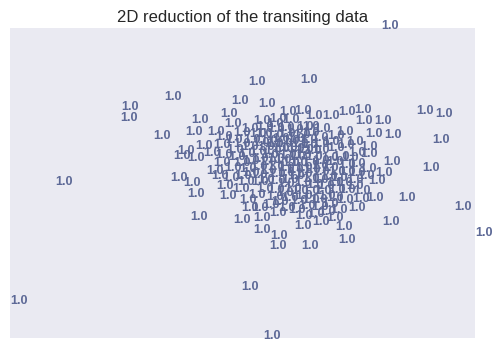

In [48]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD as TSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler, normalize

import hdbscan

# plotting function

def plot_embedding(X, Title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(Y[i]),
                 color=plt.cm.Set1(Y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])
    if Title is not None:
        plt.title(Title)


# Section to read unbalanced 3 planets data set

balanced = np.loadtxt('three_planets_with_false_positives2.txt')
IDs = balanced[:, 1]
X = balanced[:, 3:]
Y = np.zeros(balanced.shape[0]) + 1
Y[balanced[:, 0] > 1] = 0

X_three_transiting_planets = X[:225, 3:]
Y_three_transiting_planets = Y[:225]

tsne = TSNE(n_components=2, n_iter=100000, n_iter_without_progress=1000, method='exact', metric='manhattan')

X_three_transiting_planets_reduced = tsne.fit_transform(X_three_transiting_planets)

plot_embedding(X_three_transiting_planets_reduced, Title='2D reduction of the transiting data')

Now HDB scan is applied to the above cluster

There are 2 clusters


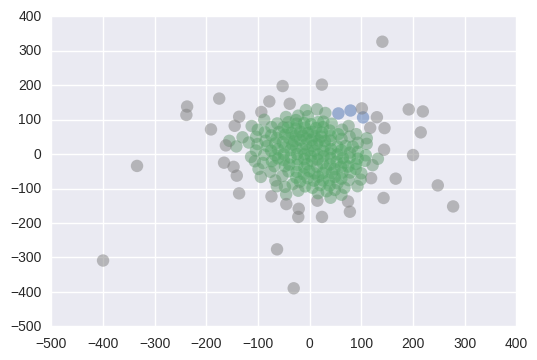

In [79]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3).fit(X_three_transiting_planets_reduced)

palette = sns.color_palette()

cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (.5, .5, .5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]

plt.scatter(X_three_transiting_planets_reduced.T[0], X_three_transiting_planets_reduced.T[1],
            c = cluster_colors, **plot_kwds)

n_clusters_ = len(set(clusterer.labels_)) - (1 if -1 in clusterer.labels_ else 0)
print("There are {0} clusters").format(n_clusters_)
plt.show()

Given the low amount of samples we need to set min_cluster_size low or all the data is categorized as noise, we see in the next cell that setting min_samples to 1 gives us 6 clusters.  

There are 6 clusters


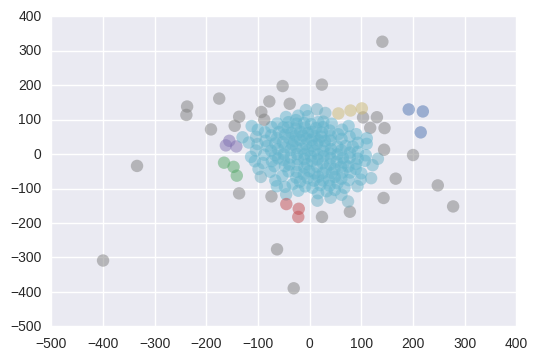

In [89]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=1).fit(X_three_transiting_planets_reduced)

palette = sns.color_palette()

cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (.5, .5, .5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]

plt.scatter(X_three_transiting_planets_reduced.T[0], X_three_transiting_planets_reduced.T[1],
            c = cluster_colors, **plot_kwds)

n_clusters_ = len(set(clusterer.labels_)) - (1 if -1 in clusterer.labels_ else 0)
print("There are {0} clusters").format(n_clusters_)
plt.show()

At this point I started to integrate the rest of the data not including the noise, you can notice in the group of ones, that a subgroup seems apparent at the botton of the cluster. 

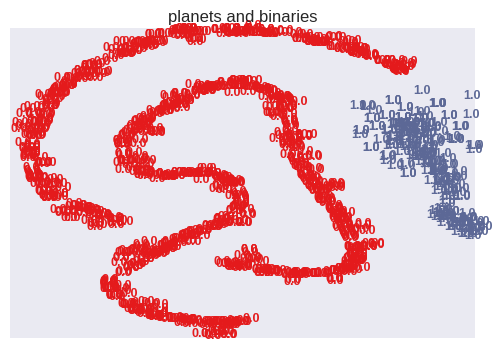

In [97]:
tsvd = TSVD(n_components=50, n_iter=10000, algorithm='arpack')

X_planets_and_binaries = tsne.fit_transform(tsvd.fit_transform(X[:1225, 3:]))
Y_planets_and_binaries = Y[:1225]
plot_embedding(X_planets_and_binaries, Title='planets and binaries')

There are 3 clusters


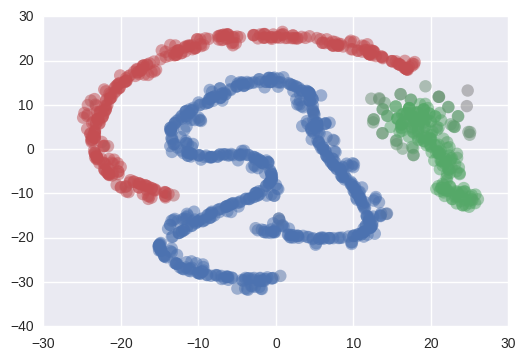

In [119]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10).fit(X_planets_and_binaries)

palette = sns.color_palette()

cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (.5, .5, .5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]

plt.scatter(X_planets_and_binaries.T[0], X_planets_and_binaries.T[1],
            c = cluster_colors, **plot_kwds)

n_clusters_ = len(set(clusterer.labels_)) - (1 if -1 in clusterer.labels_ else 0)

print("There are {0} clusters").format(n_clusters_)

plt.show()

We see that the clusterer correctly identifies 3 clusters and also that these three clusters fall into the appropriate categories, although it should be noted that some points still fall into noise. 

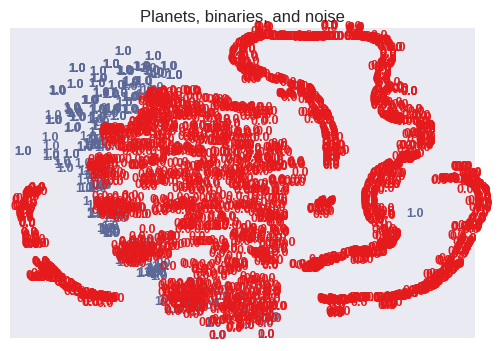

In [154]:
X_planets_binaries_noise = tsne.fit_transform(tsvd.fit_transform(X[:2225, 3:]))
plot_embedding(X_planets_binaries_noise, Title="Planets, binaries, and noise")

We can see that when fully including the noise it's quite a mess. Maybe it's due to the ratio of noise to data. 

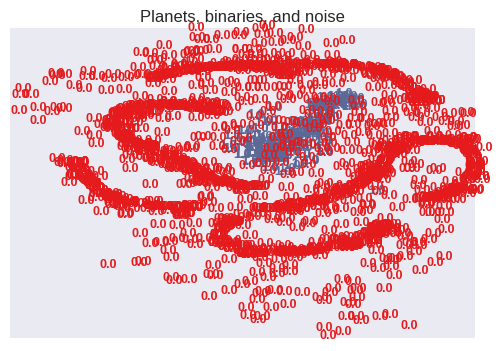

In [163]:
X_planets_binaries = tsne.fit_transform(tsvd.fit_transform(X[:1225, 3:]))

X_noise = tsne.fit_transform(StandardScaler().fit_transform(X[1225:1725, 3:]))

X_planets_binaries_noise = np.vstack((X_planets_binaries, X_noise))

plot_embedding(X_planets_binaries_noise, Title="Planets, binaries, and noise")

There are 6 clusters


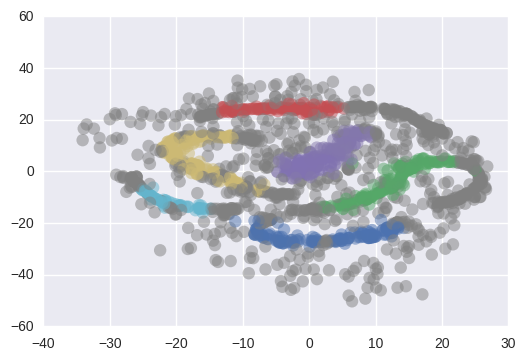

In [166]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=60).fit(X_planets_binaries_noise)

palette = sns.color_palette()

cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (.5, .5, .5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]

plt.scatter(X_planets_binaries_noise.T[0], X_planets_binaries_noise.T[1],
            c = cluster_colors, **plot_kwds)

n_clusters_ = len(set(clusterer.labels_)) - (1 if -1 in clusterer.labels_ else 0)

print("There are {0} clusters").format(n_clusters_)

plt.show()

As we see the clusterer may be picking up on the points, or both the points and labels. I will create a function that takes the clusterers labels and
the and the actual labels to observe the purple group.
